# Goals / Plan

- Using regret for the game works, but is slow
    - choosing 1 random contract per round only, 1 random action per player
    - regret is inaccurance b/c it is based on a random sample from opponent's mixed strategies; imprecise

- How can we apply regret minimization WITHOUT random sampling (use precise probabilities)?

# Symmetric Regret and Convolutions

- example scenario:
    - contract is uniform [700, 1300]
    - contract is N(1000, 150) - bonus
    - 10 players for both

- initializations:
    - realistically, assume nobody is bidding over 200
    - initialize regret of options 1-200 np.zeros(200) --> even probabilities

- calculating regret:
    - assume we have a 200-length probability vector p
    - we want to find the regret of choosing each option based on MIXED STRATEGIES of opponents + CONTRACT PDF
        - this is the key, not using random samples, but exact probabilities

regret of choosing a value x:
- convolution of the other 9 players pdfs over values < x:
    - length x, convolve 9 times --> 9x log(9x)
    - this is the distribution of the sum of other players' lower bids
- how to integrate contract pdf
    - integral of [(contract == c) * (convolution cdf < c - x)]
    - don't calculate integral, do it discrete
    - for uniform distribution, calculate each contract value, then average (600 scenarios)

time complexity of calculating regret for value x:
- convolution takes 9x log (9x) time
- turn pdf into cdf (prefix sum linear time, 9x)
- for each contract scenario, find sum of probabilities (600 time)
- overall: 9x log(9x) * 600

time complexity over all values:
- Sum x=1 to x=200 of (9x log(9x) * 600) = 10^8 about
- Expressed differently: about max x^2 * players * contract length
- Assuming max x is about max(contract) / players * 2
- O(max(contract)^2 * contract length)

change to contract is [350, 650], 10 players (still feels like enough granularity)
- now instead of 10^8, about 10^7 per iteration
- iterations converge much quicker, about 100 iterations maybe?

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
""" 
Variables to define:
    provide own reward function (given the single mixed strategy, # other players) --> calculate the reward
    support space
    number of players
"""
class SymmetricRegret:
    def __init__(self, num_players, support, rewardFunction, **kwargs):
        self.PLAYERS = num_players
        self.ACTIONS = support
        self.rewardFunction = rewardFunction
        self.kwargs = kwargs

        self.regret = np.zeros(len(support))
        self.last_regret = np.zeros(len(support))
    
    def get_strategy(self):
        ceiling = np.maximum(0, self.regret)
        if np.sum(ceiling) == 0: ceiling = np.ones(len(ceiling))
        return ceiling / np.sum(ceiling)
    
    def solve(self, trials, verbose=100):
        for i in range(trials):
            current_regret = self.rewardFunction(self.ACTIONS, self.get_strategy(), self.PLAYERS - 1, **self.kwargs)
            new_regret = self.regret + current_regret

            # Prints and breaks
            if np.isclose(np.maximum(current_regret, 0), 0, atol=1e-15).all():
                print(f"Breaking at iteration {i}")
                break
            if verbose and (i%verbose == 0): print(new_regret)

            self.regret = new_regret
            self.last_regret = current_regret

In [118]:
import numpy as np

def convolve_pdf_n_times(p, n):
    # Remove leading and trailing zeros
    start = np.argmax(p > 0)  # First non-zero index
    end = len(p) - np.argmax(p[::-1] > 0)  # Last non-zero index + 1
    p_trimmed = p[start:end]

    M = len(p_trimmed)

    # Calculate the length of the result
    out_len = n * (M - 1) + 1
    fft_len = 1
    while fft_len < out_len:
        fft_len <<= 1  # Multiply by 2

    # Zero-pad the trimmed array
    p_padded = np.zeros(fft_len, dtype=np.float64)
    p_padded[:M] = p_trimmed

    # FFT, convolution (power), and IFFT
    P = np.fft.fft(p_padded)
    Pn = P ** n
    conv_n = np.fft.ifft(Pn)

    # Retain the real part and trim to the desired length
    conv_n = np.real_if_close(conv_n, tol=1e5)
    conv_n = conv_n[:out_len]

    # Add back the effect of trimming
    final_result = np.zeros(n * (len(p) - 1) + 1, dtype=np.float64)
    final_result[start * n:(start * n) + len(conv_n)] = conv_n

    return final_result



In [119]:
def uniformRegret(actions, strategy, num_players, CONTRACT_MIN, CONTRACT_MAX):
    assert len(actions) == len(strategy)

    rewards = np.zeros(len(actions))
    zero_padded_strategies = np.concatenate([np.zeros(min(actions)), strategy])

    for i, x in enumerate(actions):
        # find the convolved cdf
        convolved = convolve_pdf_n_times(zero_padded_strategies[:x+1], num_players) # we always LOSE the ties
        for j in range(len(convolved)-1): convolved[j+1] += convolved[j]

        # find the reward
        probability = 0
        for contract_val in range(CONTRACT_MIN, CONTRACT_MAX + 1):
            value_threshold = contract_val - x # convolution needs to sum to <= value threshold, for us to get filled
            probability += convolved[value_threshold] if value_threshold < len(convolved) else 1
        probability = probability/ (CONTRACT_MAX - CONTRACT_MIN + 1)

        # rewards
        rewards[i] = probability * x

    avg_reward = rewards * strategy
    regret = rewards - np.sum(avg_reward)
    return regret

In [120]:
NUM_PLAYERS = 10
ACTIONS = np.arange(30, 50)

r = SymmetricRegret(NUM_PLAYERS, ACTIONS, uniformRegret, CONTRACT_MIN=350, CONTRACT_MAX=650)
r.solve(1000, verbose=None)
strategy = r.get_strategy()
strategy

Breaking at iteration 56


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.42290495, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.57709505])

<Axes: >

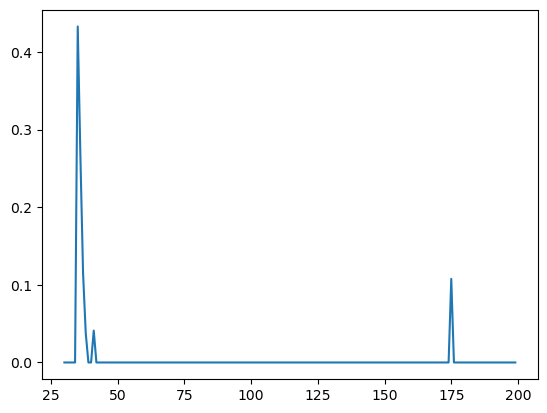

In [112]:
sns.lineplot(x=ACTIONS, y=strategy)

In [105]:
NUM_PLAYERS = 3
ACTIONS = np.arange(1, 10)

r = SymmetricRegret(NUM_PLAYERS, ACTIONS, uniformRegret, CONTRACT_MIN=9, CONTRACT_MAX=12)
r.solve(1000, verbose=None)
strategy = r.get_strategy()
strategy

Breaking at iteration 13


array([0.        , 0.        , 0.95825423, 0.04174577, 0.        ,
       0.        , 0.        , 0.        , 0.        ])